Demonstration of GPR for PIRI data with unit trends

In [54]:
# load packages
import torch
print(torch.__version__)
import numpy as np
import pandas as pd
import gpytorch
print(gpytorch.__version__)
from typing import Optional, Tuple
from matplotlib import pyplot as plt
from gpytorch.means import LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from statsmodels.stats.stattools import durbin_watson
from matplotlib import pyplot as plt

1.12.1
1.8.1


Implement constant mean module and mask mean module

In [55]:
class ConstantVectorMean(gpytorch.means.mean.Mean):
    def __init__(self, d=1, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, d)))
        if prior is not None:
            self.register_prior("mean_prior", prior, "constantvector")

    def forward(self, input):
        return self.constantvector[input.int().reshape((-1,)).tolist()]
    
class MaskMean(gpytorch.means.mean.Mean):
    def __init__(
        self,
        base_mean: gpytorch.means.mean.Mean,
        active_dims: Optional[Tuple[int, ...]] = None,
        **kwargs,
    ):
        super().__init__()
        if active_dims is not None and not torch.is_tensor(active_dims):
            active_dims = torch.tensor(active_dims, dtype=torch.long)
        self.active_dims = active_dims
        self.base_mean = base_mean
    
    def forward(self, x, **params):
        return self.base_mean.forward(x.index_select(-1, self.active_dims), **params)

load data with last 5 years splitting:

In [56]:
def load_PIRI_data():
    # read data
    data = pd.read_csv("hb_data_complete.csv", index_col=[0])

    # all zero PIRI for new zealand and netherland
    data = data.loc[~data['country'].isin(['N-ZEAL','NETHERL'])]

    countries = sorted(data.country.unique())
    years = data.year.unique()
    n = len(countries)
    m = len(years)

    # build data
    country_dict = dict(zip(countries, range(n)))
    year_dict = dict(zip(years, range(m)))

    # x is:
    # 1: year number
    # 2: country id
    # 3: AIShame (treatment indicator)
    # 4: cat_rat
    # 5: ccpr_rat
    # 6: democratic
    # 7: log(gdppc)
    # 8: log(pop)
    # 9: Civilwar2
    # 10: War
    x = torch.zeros(data.shape[0], 10)
    x[:,0] = torch.as_tensor(list(map(year_dict.get, data.year)))
    x[:,1] = torch.as_tensor(list(map(country_dict.get, data.country)))
    x[:,2] = torch.as_tensor(data.AIShame.to_numpy())
    x[:,3] = torch.as_tensor(data.cat_rat.to_numpy())
    x[:,4] = torch.as_tensor(data.ccpr_rat.to_numpy())
    x[:,5] = torch.as_tensor(data.democratic.to_numpy())
    x[:,6] = torch.as_tensor(data.log_gdppc.to_numpy())
    x[:,7] = torch.as_tensor(data.log_pop.to_numpy())
    x[:,8] = torch.as_tensor(data.Civilwar2.to_numpy())
    x[:,9] = torch.as_tensor(data.War.to_numpy())
    y = torch.as_tensor(data.PIRI.to_numpy()).double()

    # split data into training and testing by last 5 years
    train_mask = x[:,0] < (m-5)
    train_x = x[train_mask]
    test_x = x[~train_mask]
    train_y = y[train_mask]
    test_y = y[~train_mask]

    unit_means = torch.zeros(n,)
    for i in range(n):
        unit_means[i] = train_y[train_x[:,1]==i].mean()

    return train_x.double(), train_y.double(), test_x.double(), test_y.double(), unit_means.double(), data, countries, years

train_x, train_y, test_x, test_y, unit_means, data, countries, years = load_PIRI_data()

Build GPR model with unit trends

In [57]:
# model specification: PIRI gp model with unit trends
# PIRI ~ AIShame + u_i(t) + cat_rat + ccpr_rat 
#            + democratic + log(gdppc) + log(pop) 
#            + Civilwar2 + War
# u_i(t) ~ GP(b_i, K_t)

class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, ard_num_dim=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = MaskMean(active_dims=1, \
                base_mean=ConstantVectorMean(d=train_x[:,1].unique().size()[0]))
        # year kernel * country kernel
        self.unit_covar_module = ScaleKernel(RBFKernel(active_dims=0)*RBFKernel(active_dims=1))
        self.x_covar_module = torch.nn.ModuleList([ScaleKernel(RBFKernel(\
            active_dims=(i))) for i in [6,7]])
        self.binary_covar_module = torch.nn.ModuleList([ScaleKernel(RBFKernel(\
            active_dims=(i))) for i in [3,4,5,8,9]])
        self.effect_covar_module = ScaleKernel(RBFKernel(active_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        unit_covar_x = self.unit_covar_module(x)
        effect_covar_x = self.effect_covar_module(x)
        covar_x = unit_covar_x + effect_covar_x
        for i, _ in enumerate(self.x_covar_module):
            covar_x += self.x_covar_module[i](x)
        for i, _ in enumerate(self.binary_covar_module):
            covar_x += self.binary_covar_module[i](x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

initialize model

In [58]:
likelihood = GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood).double()

# initialize model parameters
hypers = {
    'mean_module.base_mean.constantvector': unit_means,
    'likelihood.noise_covar.noise': torch.tensor(0.25),
    'unit_covar_module.base_kernel.kernels.0.lengthscale': torch.tensor(4),
    'unit_covar_module.base_kernel.kernels.1.lengthscale': torch.tensor(0.01),
    'unit_covar_module.outputscale': torch.tensor(0.25),
    'x_covar_module.0.outputscale': torch.tensor(0.25),
    'x_covar_module.1.outputscale': torch.tensor(0.25),
    'binary_covar_module.0.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.1.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.2.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.3.base_kernel.lengthscale': torch.tensor(0.01),
    'binary_covar_module.4.base_kernel.lengthscale': torch.tensor(0.01),
    'effect_covar_module.base_kernel.lengthscale': torch.tensor(0.01),
    'effect_covar_module.outputscale': torch.tensor(0.25)
}    

model.initialize(**hypers)

GPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): MaskMean(
    (base_mean): ConstantVectorMean()
  )
  (unit_covar_module): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (1): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
  (x_covar_module): ModuleList(
    (0): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
    (1): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (binary_covar_module): ModuleList(
    (0): ScaleKernel(
      (base_kernel): RBFKerne

train model by optimizing hypers

In [59]:
# train model
model.train()
likelihood.train()

torch.manual_seed(12345)

# freeze length scale in the country component in unit covar
# freeze constant unit means
all_params = set(model.parameters())
final_params = list(all_params - \
            {model.unit_covar_module.base_kernel.kernels[1].raw_lengthscale, \
            model.mean_module.base_mean.constantvector, \
        #   model.x_covar_module[0].raw_outputscale,
        #   model.x_covar_module[1].raw_outputscale,
            model.binary_covar_module[0].base_kernel.raw_lengthscale,
            model.binary_covar_module[1].base_kernel.raw_lengthscale,
            model.binary_covar_module[2].base_kernel.raw_lengthscale,
            model.binary_covar_module[3].base_kernel.raw_lengthscale,
            model.binary_covar_module[4].base_kernel.raw_lengthscale,
            model.effect_covar_module.base_kernel.raw_lengthscale})
        #   model.effect_covar_module.raw_outputscale})
optimizer = torch.optim.Adam(final_params, lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f '  % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()

torch.save(model.state_dict(), "PIRI_GPR_model_5yr.pth")

Iter 1/100 - Loss: 2.358 
Iter 2/100 - Loss: 2.252 
Iter 3/100 - Loss: 2.132 
Iter 4/100 - Loss: 2.029 
Iter 5/100 - Loss: 1.956 
Iter 6/100 - Loss: 1.887 
Iter 7/100 - Loss: 1.835 
Iter 8/100 - Loss: 1.787 
Iter 9/100 - Loss: 1.752 
Iter 10/100 - Loss: 1.717 
Iter 11/100 - Loss: 1.691 
Iter 12/100 - Loss: 1.665 
Iter 13/100 - Loss: 1.645 
Iter 14/100 - Loss: 1.639 
Iter 15/100 - Loss: 1.619 
Iter 16/100 - Loss: 1.607 
Iter 17/100 - Loss: 1.605 
Iter 18/100 - Loss: 1.605 
Iter 19/100 - Loss: 1.601 
Iter 20/100 - Loss: 1.586 
Iter 21/100 - Loss: 1.589 
Iter 22/100 - Loss: 1.593 
Iter 23/100 - Loss: 1.588 
Iter 24/100 - Loss: 1.586 
Iter 25/100 - Loss: 1.588 
Iter 26/100 - Loss: 1.592 
Iter 27/100 - Loss: 1.588 
Iter 28/100 - Loss: 1.590 
Iter 29/100 - Loss: 1.591 
Iter 30/100 - Loss: 1.593 
Iter 31/100 - Loss: 1.592 
Iter 32/100 - Loss: 1.592 
Iter 33/100 - Loss: 1.593 
Iter 34/100 - Loss: 1.594 
Iter 35/100 - Loss: 1.591 
Iter 36/100 - Loss: 1.589 
Iter 37/100 - Loss: 1.583 
Iter 38/10

generate posterior of PIRI effects

In [60]:
model.load_state_dict(torch.load('PIRI_GPR_model_5yr.pth'))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = likelihood(model(train_x))
    mu_f = out.mean
    V = out.covariance_matrix
    L = torch.linalg.cholesky(V, upper=False)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model.unit_covar_module.outputscale = 0
    for i,_ in enumerate(model.x_covar_module):
        model.x_covar_module[i].outputscale = 0
    for i,_ in enumerate(model.binary_covar_module):
        model.binary_covar_module[i].outputscale = 0
    effect_covar = model(train_x).covariance_matrix

# get posterior effect mean
alpha = torch.linalg.solve(L.t(),torch.linalg.solve(L,train_y-mu_f))
tmp = torch.linalg.solve(L, effect_covar)
post_effect_mean = effect_covar @ alpha
# get posterior effect covariance
post_effect_covar = effect_covar - tmp.t() @ tmp

effect = post_effect_mean[train_x[:,2]==1].mean() - post_effect_mean[train_x[:,2]==0].mean()
effect_std = post_effect_covar.diag().mean().sqrt()
BIC = (2+4+6+1)*torch.log(torch.tensor(train_x.size()[0])) + 2*loss*train_x.size()[0]
print("effect: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*train_x.size()[0]))
print("BIC: {:0.3f} \n".format(BIC))

effect: 0.335 +- 0.152

model evidence: -2331.979 

BIC: 4758.820 



Perform Durbin Watson tests for autocorrelation

In [61]:
# get unit trend wo AIShame
model.load_state_dict(torch.load('PIRI_GPR_model_5yr.pth'))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model.effect_covar_module.outputscale = 0
    unit_covar = likelihood(model(train_x)).covariance_matrix

# get posterior unit trend mean
alpha = torch.linalg.solve(L.t(),torch.linalg.solve(L,train_y-mu_f))
tmp = torch.linalg.solve(L, unit_covar)
post_unit_mean = mu_f + unit_covar @ alpha + post_effect_mean

# DW-test for sample size = 13 and 8 regressors.
dL = 0.147
dU = 3.266
n = len(countries)
DW_results = np.zeros((n,))
for i in range(n):
    mask = (train_x[:,1]==i).numpy()
    res = train_y[mask] - post_unit_mean[mask]
    DW_results[i] = durbin_watson(res.detach().numpy())

print("{} out of {} residuals are positively correlated.\n".format(np.sum(DW_results<=dL),n))
print("{} out of {} residuals are negatively correlated.\n".format(np.sum(DW_results>=dU),n))
print("{} out of {} residuals are not correlated.\n".format(np.sum((DW_results>dL) & (DW_results<dU)),n))
    

5 out of 138 residuals are positively correlated.

0 out of 138 residuals are negatively correlated.

133 out of 138 residuals are not correlated.



In [62]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    y_pred = model(test_x)

In [63]:
y_pred_np = y_pred.mean.numpy() #convert to Numpy array

df = pd.DataFrame(y_pred_np) #convert to a dataframe
df['true_y'] = test_y
df.to_csv("predicted_5_year.csv",index=False) #save to file

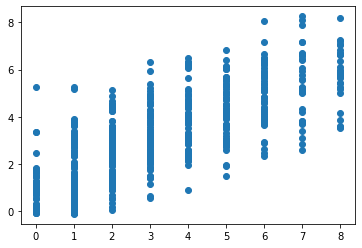

In [64]:
plt.scatter(test_y.numpy(),y_pred_np)